In [3]:
import pymongo
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
client = pymongo.MongoClient("mongodb://localhost:27017/")

In [5]:
db = client["Global_Coffee_Consumption"]

In [6]:
collection_names = db.list_collection_names()

In [7]:
print(collection_names)

['Coffee_DomesticConsumption', 'Coffee_exports', 'Coffee_production', 'Coffee_imports', 'Coffee_ImportersConsumption']


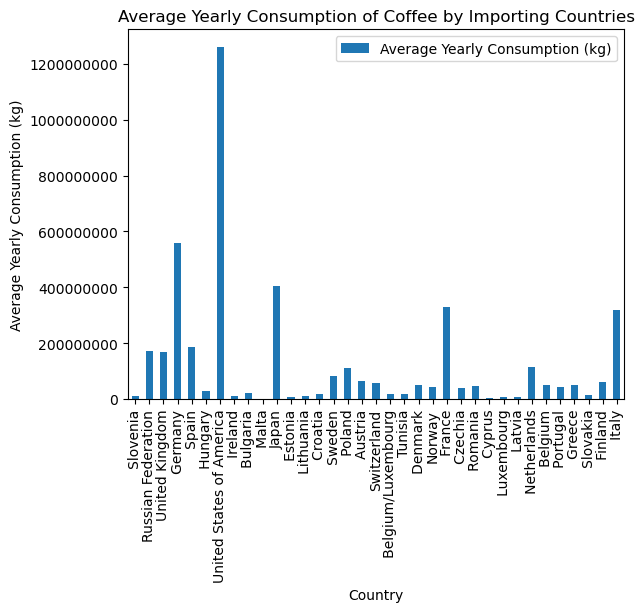

In [8]:
import_consumption = db['Coffee_ImportersConsumption'] 

#Query for finding country names
importers_data_query = import_consumption.aggregate([
    {"$group": 
     {"_id":{
        "Country": "$Country"}, 
                "count": {'$sum': 1}    
    }}
])

#Query for calculating the average consumption per year
importers_avg_query =      {
        "$group": {
            "_id":  "$Country",
            "avgConsumptionTotal": {"$avg": {"$divide": ["$Total_import_consumption", 30]}}
        }
}

pipeline = [importers_avg_query]

results = list(import_consumption.aggregate(pipeline))

importers_data = []

#Add dictionaries to list
for result in results:
    importers_data.append(result)

#Create dataframe
importers_df = pd.DataFrame(importers_data)
importers_df = importers_df.rename(columns={"_id": "Country",
                                           "avgConsumptionTotal": "Average Yearly Consumption (kg)"})
#Plot bar chart
importers_df.plot(kind="bar",
                 x="Country",
                 y="Average Yearly Consumption (kg)",
                 title="Average Yearly Consumption of Coffee by Importing Countries")
plt.xlabel("Country")
plt.ylabel("Average Yearly Consumption (kg)")

#Format the y-axis ticks in full decimal form
ax = plt.gca()
ax.yaxis.set_major_formatter('{:.0f}'.format)

plt.show()

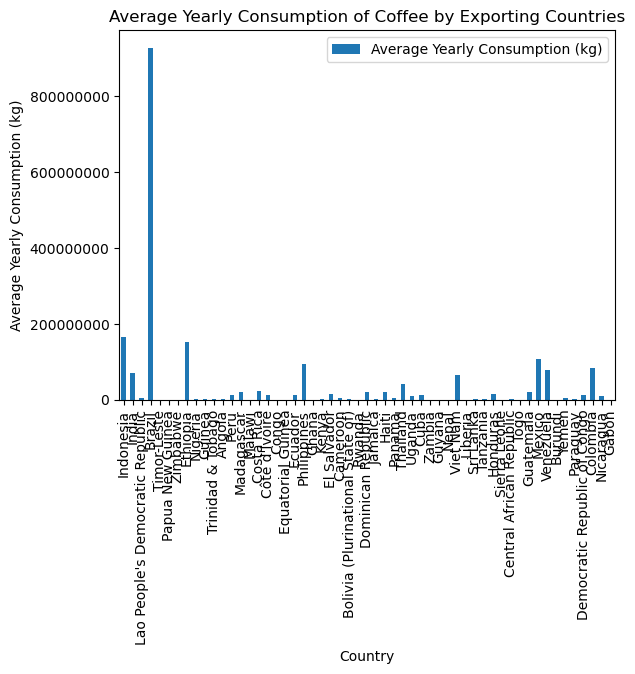

In [9]:
export_consumption = db['Coffee_DomesticConsumption'] 

#Query for finding country names
exporters_data_query = export_consumption.aggregate([
    {"$group": 
     {"_id":{
        "Country": "$Country"}, 
                "count": {'$sum': 1}    
    }}
])

#Query for calculating the average consumption per year
exporters_avg_query =      {
        "$group": {
            "_id":  "$Country",
            "avgConsumptionTotal": {"$avg": {"$divide": ["$Total_domestic_consumption", 30]}}
        }
}

pipeline = [exporters_avg_query]

results = list(export_consumption.aggregate(pipeline))

exporters_data = []

#Add dictionaries to list
for result in results:
    exporters_data.append(result)

#Create dataframe
exporters_df = pd.DataFrame(exporters_data)
exporters_df = exporters_df.rename(columns={"_id": "Country",
                                           "avgConsumptionTotal": "Average Yearly Consumption (kg)"})
#Plot bar chart
exporters_df.plot(kind="bar",
                 x="Country",
                 y="Average Yearly Consumption (kg)",
                 title="Average Yearly Consumption of Coffee by Exporting Countries")
plt.xlabel("Country")
plt.ylabel("Average Yearly Consumption (kg)")

#Format the y-axis ticks in full decimal form
ax = plt.gca()
ax.yaxis.set_major_formatter('{:.0f}'.format)

plt.show()

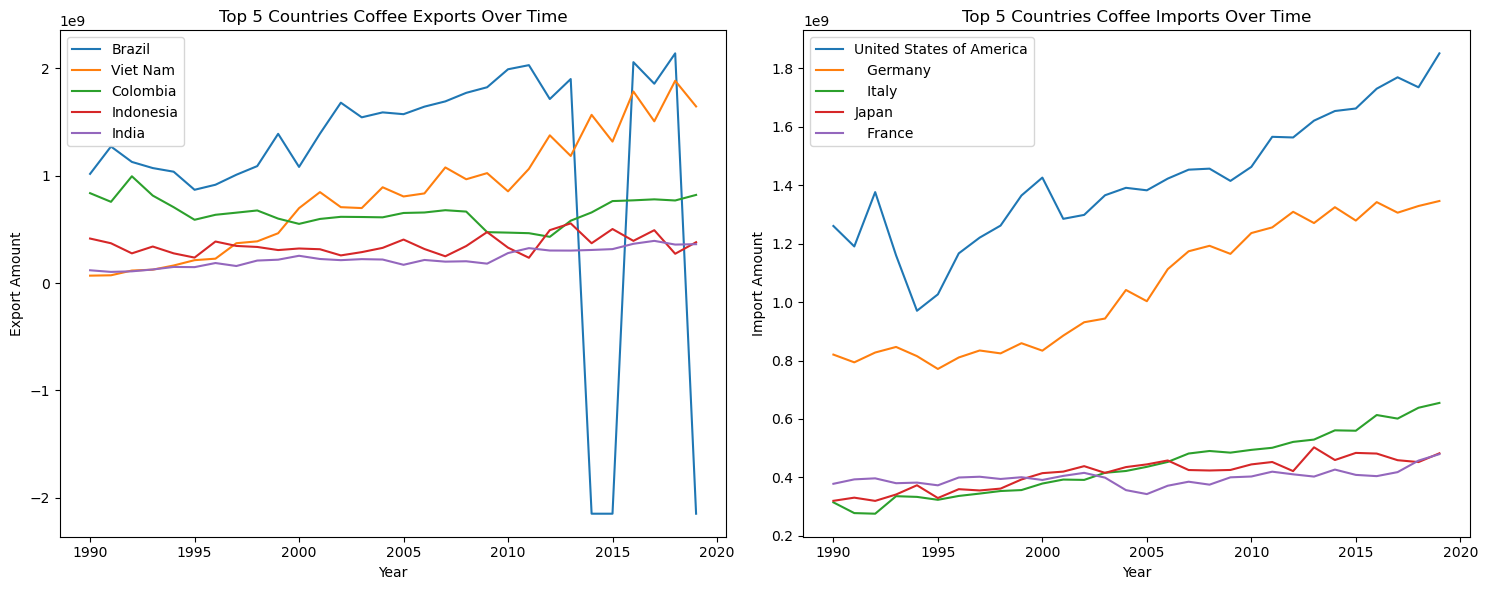

In [10]:
import pymongo
import pandas as pd
import matplotlib.pyplot as plt

# Connect to MongoDB
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["Global_Coffee_Consumption"]

# Select the collections for exports and imports
exports_collection = db['Coffee_exports']
imports_collection = db['Coffee_imports']

# Aggregate query to calculate the total exports and imports for each country
exports_total_pipeline = [
    {"$group": {"_id": "$Country", "total_export": {"$sum": "$Total_export"}}},
    {"$sort": {"total_export": -1}},
    {"$limit": 5}
]
exports_total = list(exports_collection.aggregate(exports_total_pipeline))

imports_total_pipeline = [
    {"$group": {"_id": "$Country", "total_import": {"$sum": "$Total_import"}}},
    {"$sort": {"total_import": -1}},
    {"$limit": 5}
]
imports_total = list(imports_collection.aggregate(imports_total_pipeline))

# Get the names of the top 5 exporting and importing countries
top_export_countries = [doc['_id'] for doc in exports_total]
top_import_countries = [doc['_id'] for doc in imports_total]

# Query the annual export and import data for these top countries
exports_query = {"Country": {"$in": top_export_countries}}
imports_query = {"Country": {"$in": top_import_countries}}

exports_data = list(exports_collection.find(exports_query))
imports_data = list(imports_collection.find(imports_query))

# Transform data to a format suitable for plotting
exports_df = pd.DataFrame(exports_data).melt(id_vars=['Country'], var_name='Year', value_name='ExportAmount')
imports_df = pd.DataFrame(imports_data).melt(id_vars=['Country'], var_name='Year', value_name='ImportAmount')

# Filter data to keep only rows with year and numeric values
exports_df = exports_df[exports_df['Year'].apply(lambda x: x.isdigit())]
imports_df = imports_df[imports_df['Year'].apply(lambda x: x.isdigit())]

# Convert year to integer
exports_df['Year'] = exports_df['Year'].astype(int)
imports_df['Year'] = imports_df['Year'].astype(int)

# Plot the line charts
plt.figure(figsize=(15, 6))

# Plot exports chart
plt.subplot(1, 2, 1)
for country in top_export_countries:
    country_data = exports_df[exports_df['Country'] == country]
    plt.plot(country_data['Year'], country_data['ExportAmount'], label=country)
plt.title('Top 5 Countries Coffee Exports Over Time')
plt.ylabel('Export Amount')
plt.xlabel('Year')
plt.legend()

# Plot imports chart
plt.subplot(1, 2, 2)
for country in top_import_countries:
    country_data = imports_df[imports_df['Country'] == country]
    plt.plot(country_data['Year'], country_data['ImportAmount'], label=country)
plt.title('Top 5 Countries Coffee Imports Over Time')
plt.ylabel('Import Amount')
plt.xlabel('Year')
plt.legend()

plt.tight_layout()
plt.show()



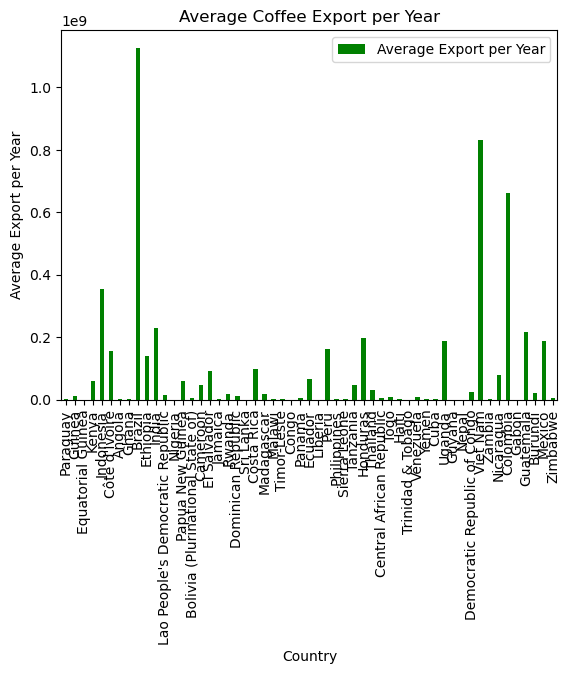

In [11]:
#Which countries export the most coffee?
#Create database
export_countries = db['Coffee_exports']

#Get country names
export_query = export_countries.aggregate([
    {"$group":
        {"_id":{
           "Country": "$Country"},
                 "count": {'$sum' : 1}
        }}
])

#Calculate average export per year, for last 30 years
avg_export_query = {
    "$group": {
        "_id": "$Country",
        "avgExport": {"$avg": {"$divide": ["$Total_export", 30]}}
    }
}

# Store results in a dictionary
pipeline = [avg_export_query]
results = list(export_countries.aggregate(pipeline))

#Create list for results, add results to list
avg_export_data = []

for result in results:
    avg_export_data.append(result)
    
# Create dataframe of results list
avg_export_df = pd.DataFrame(avg_export_data)
avg_export_df = avg_export_df.rename(columns = {"_id" : "Country",
                                                "avgExport" : "Average Export per Year"})    

# Plot bar chart
avg_export_df.plot(kind = "bar",
                  x = "Country",
                  y = "Average Export per Year",
                  title = "Average Coffee Export per Year",
                  color = "green")
plt.xlabel("Country")
plt.ylabel("Average Export per Year")
plt.show()

In [12]:
#Coffee production heatmap
#Create database
production_countries = db['Coffee_production']

#Get country names
production_query = production_countries.aggregate([
    {"$group":
        {"_id":{
            "Country": "$Country"},
                 "count": {'$sum' : 1}
        }}
])

In [13]:
#Calculate total production
total_export_query = {
    "$group": {
        "_id": "$Country",
        "totalproduction": {"$sum": {"$sum" : ["$Total_production"]}}
    }
}

In [14]:
#Store results in a dictionary
pipeline = [total_export_query]
results = list(production_countries.aggregate(pipeline))

#Create list for results, add results to list
total_production_data = []

for result in results:
    total_production_data.append(result)

In [15]:
#Create dataframe of results list
total_production_df = pd.DataFrame(total_production_data)
total_production_df = total_production_df.rename(columns = {"_id" : "Country",
                                                           "totalproduction" : "Coffee Production"})

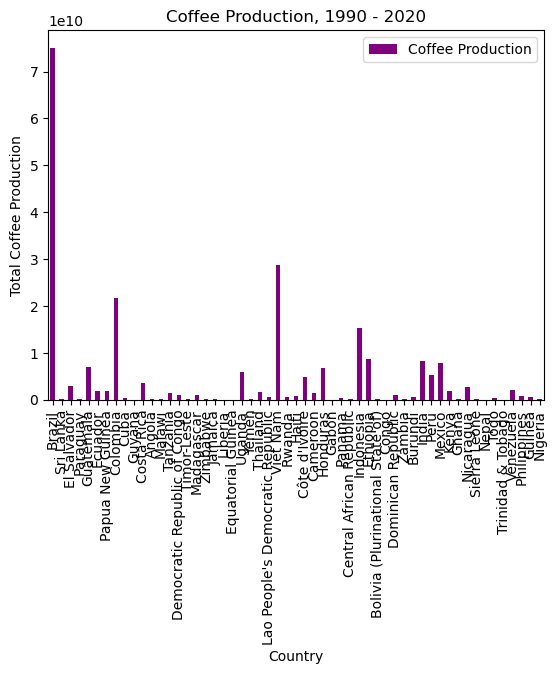

In [16]:
total_production_df.plot(kind = "bar",
                  x = "Country",
                  y = "Coffee Production",
                  title = "Coffee Production, 1990 - 2020",
                  color = "purple")
plt.xlabel("Country")
plt.ylabel("Total Coffee Production")
plt.show()

In [17]:
#Global map of coffee production
#Import dependencies
import requests
import json
import hvplot.pandas
import pandas as pd
geoapify_key = "f89649cb87324778b6a5d5fe7f466a73"

In [18]:
#Create database
production_map_df = pd.DataFrame(total_production_df["Country"])
production_map_df["30 Year Production"] = total_production_df["Coffee Production"]

In [22]:
lats = []
lons = []

for country in total_production_df["Country"]:
    target_country = country
    target_url = f"https://api.geoapify.com/v1/geocode/search?text={target_country}&format=json&apiKey={geoapify_key}"
    geo_data = requests.get(target_url).json()
    lats.append(geo_data["results"][0]["lat"])
    lons.append(geo_data["results"][0]["lon"])
    
print(lats)

[-10.3333333, 7.5554942, 13.8000382, -23.3165935, 15.5855545, -1.3397668, -5.6816069, 4.099917, 23.0131338, 4.8417097, 9.536456900000001, -11.8775768, -13.2687204, -6.5247123, -15.4139213, -8.7443169, -18.9249604, -18.4554963, 18.1850507, 5.7499721, 1.613172, 1.5333554, 16.3471243, 14.8971921, 20.0171109, 15.9266657, -1.9646631, 19.1399952, 7.9897371, 4.6125522, 15.2572432, -0.8999695, 8.559559, 7.0323598, -2.4833826, 10.2116702, -17.0568696, -2.9814344, 19.0974031, -14.5189121, -3.426449, 22.3511148, -6.8699697, 23.6585116, 1.4419683, 8.0300284, 12.6090157, 8.6400349, 28.1083929, 8.7800265, 32.1440417, 8.0018709, 12.7503486, 10.7226226, 9.6000359]


In [23]:
lats_df = pd.DataFrame(lats)
lons_df = pd.DataFrame(lons)

In [24]:
production_map_df["Latitude"] = lats_df[0]
production_map_df["Longitude"] = lons_df[0]

In [27]:
production_map_plot = production_map_df.hvplot.points(
    "Longitude",
    "Latitude",
    geo = True,
    tiles = "OSM",
    frame_width = 700,
    frame_height = 500,
    size = "30 Year Production",
    scale = 0.0002,
    color = "Country")

production_map_plot

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (Country,30 Year Production)